# Student Subjectivity in Course Evaluations

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\surfd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\surfd\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Create the dataset

In [3]:
# read in the clean csv data extracted from pdf / webscraping
set_df = pd.read_csv('../DATA/cleaned/cleaned-set.csv')
tcf_df = pd.read_csv('../DATA/cleaned/cleaned-tcf.csv')

In [4]:
# print out the size of each dataset
print(set_df.shape)
print(tcf_df.shape)

(614, 1)
(408, 11)


In [5]:
# Calculate sentiment analysis scores
sia = SentimentIntensityAnalyzer()

tcf_df['Compound Score'] = tcf_df['Review Text'].apply(lambda text: sia.polarity_scores(text)["compound"])
tcf_df['Positive Score'] = tcf_df['Review Text'].apply(lambda text: sia.polarity_scores(text)["pos"])
tcf_df['Neutral Score'] = tcf_df['Review Text'].apply(lambda text: sia.polarity_scores(text)["neu"])
tcf_df['Negative Score'] = tcf_df['Review Text'].apply(lambda text: sia.polarity_scores(text)["neg"])
tcf_df["Extremity"] = tcf_df['Compound Score'].abs()

set_df['Compound Score'] = set_df['Comments'].apply(lambda text: sia.polarity_scores(text)["compound"])
set_df['Positive Score'] = set_df['Comments'].apply(lambda text: sia.polarity_scores(text)["pos"])
set_df['Neutral Score'] = set_df['Comments'].apply(lambda text: sia.polarity_scores(text)["neu"])
set_df['Negative Score'] = set_df['Comments'].apply(lambda text: sia.polarity_scores(text)["neg"])
set_df["Extremity"] = set_df['Compound Score'].abs()

In [6]:
# Join the two datasets together, first by adding which source column explaining where each review is coming from 
set_df['Source'] = 'SET'

# remove all the extra fields within theCourseForum dataset and rename "Review Text" to "Comments" to be consistent with the SET dataset
mini_tcf_df = tcf_df[['Review Text', 'Compound Score', 'Positive Score', 'Neutral Score', 'Negative Score']]
mini_tcf_df['Source'] = 'TCF'
mini_tcf_df = mini_tcf_df.rename(columns={"Review Text":"Comments"})

# join the two datasets
df = pd.concat([set_df, mini_tcf_df])

# move "Source" to be the first column
source_col = df.pop('Source')
df.insert(0, 'Source', source_col)

# save dataframe to csv
#df.to_csv('student_eval_data.csv', index=False)

C:\Users\surfd\AppData\Local\Temp\ipykernel_21380\82295540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_tcf_df['Source'] = 'TCF'


## Exploratory Data Analysis
In this section, we will analyze the datasets from the two different sources and explore what the distribution of the data looks like for each.

### SET Data

#### Most Frequent Adjectives

In [7]:
# collect stopwords from the wordcloud library
stopwords = set(STOPWORDS)

In [8]:
# tokenize each word within a review
set_df['Tokenized Review'] = set_df['Comments'].apply(lambda text: word_tokenize(text))

In [9]:
from collections import Counter

# find all adjectives within each review
all_adjectives = []
for tokens in set_df['Tokenized Review']:
    tagged_tokens = nltk.pos_tag(tokens)
    adjectives = [word for word, pos in tagged_tokens if pos.startswith('JJ')]
    all_adjectives.extend(adjectives)

# consolidate the adjectives into a list and produce counts for each adjectives
filtered_adjectives = [adj for adj in all_adjectives if adj.lower() not in stopwords]
adjective_counts = Counter(filtered_adjectives)
most_common_adjectives = adjective_counts.most_common(10)
print(most_common_adjectives)

[('great', 77), ('good', 69), ('interesting', 44), ('hard', 34), ('helpful', 29), ('difficult', 28), ('major', 21), ('Overall', 20), ('real', 20), ('first', 20)]


#### Word Cloud

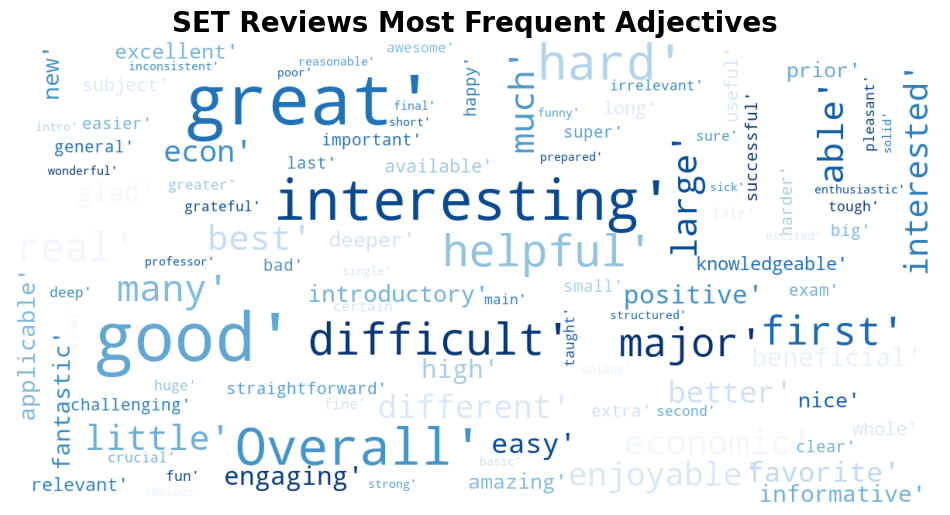

In [10]:
# generate word cloud using the inputed word list data
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1,
        colormap="Blues_r")

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.title("SET Reviews Most Frequent Adjectives", fontsize=20, fontweight='bold')
    plt.show()

# use only the adjectives
show_wordcloud(filtered_adjectives)

#### Compound Score Analysis
In the next few cells, we will analyze the compound score of the SET evaluations.

In [11]:
var = "Compound Score"
# find general statistics of the compound score distribution
print(set_df[var].describe(),'\n')

count    614.000000
mean       0.507220
std        0.384798
min       -0.898100
25%        0.361200
50%        0.597400
75%        0.795400
max        0.991800
Name: Compound Score, dtype: float64 



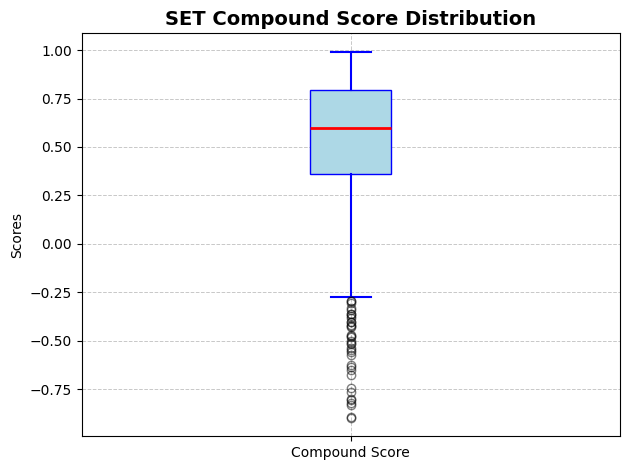

In [12]:
# Create box plot with the SET review compound scores

set_df[var].plot.box(
    patch_artist=True,  # Enable custom colors
    boxprops=dict(facecolor='lightblue', color='blue'),  # box
    medianprops=dict(color='red', linewidth=2),  # median line
    whiskerprops=dict(color='blue', linewidth=1.5),  # whiskers
    capprops=dict(color='blue', linewidth=1.5),  # caps
    flierprops=dict(marker='o', color='orange', alpha=0.5),  # outliers
)

plt.title("SET Compound Score Distribution", fontsize=14, fontweight='bold')
plt.ylabel('Scores')

# Customizing the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Adding some padding
plt.tight_layout()

plt.show()

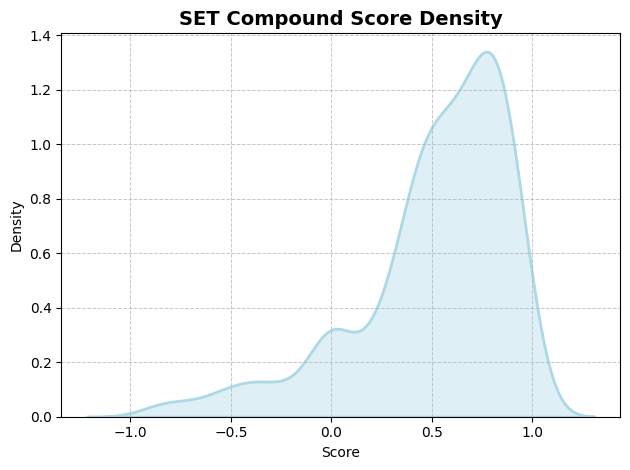

In [13]:
# Create a kernel density plot for the compound score

sns.kdeplot(set_df[var], 
            color='lightblue',  # Set line color
            fill=True,  # Fill under the KDE curve
            alpha=0.4,  # Transparency of the fill
            linewidth=2)  # Thickness of the line

# Add title and labels
plt.title("SET Compound Score Density", fontsize=14, fontweight='bold')
plt.xlabel('Score')  # X-axis label
plt.ylabel('Density')  # Y-axis label

# Add a grid with custom style
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

#### Comments that have the top five highest scores.

In [14]:
# Organize based on top 5 compound score
set_df.sort_values(by=["Compound Score"], ascending=True).head()

,Comments,Compound Score,Positive Score,Neutral Score,Negative Score,Extremity,Source,Tokenized Review
201,It was great to learn from such an established...,-0.8981,0.065,0.742,0.193,0.8981,SET,"[It, was, great, to, learn, from, such, an, es..."
458,The lack of open rubric to the students when n...,-0.8957,0.000,0.670,0.330,0.8957,SET,"[The, lack, of, open, rubric, to, the, student..."
148,My expo experience was very bad and did not he...,-0.8328,0.000,0.555,0.445,0.8328,SET,"[My, expo, experience, was, very, bad, and, di..."
236,The content in lectures could be covered more ...,-0.8196,0.000,0.831,0.169,0.8196,SET,"[The, content, in, lectures, could, be, covere..."
506,I was frustrated with the use of iClicker beca...,-0.8047,0.000,0.796,0.204,0.8047,SET,"[I, was, frustrated, with, the, use, of, iClic..."


In [15]:
# Organize based on top 5 extremity
set_df.sort_values(by=["Extremity"], ascending=False).head()

,Comments,Compound Score,Positive Score,Neutral Score,Negative Score,Extremity,Source,Tokenized Review
447,I am not an economics major or an intended pre...,0.9918,0.250,0.734,0.016,0.9918,SET,"[I, am, not, an, economics, major, or, an, int..."
422,Lectures were very engaging if you paid attent...,0.9891,0.241,0.737,0.022,0.9891,SET,"[Lectures, were, very, engaging, if, you, paid..."
224,Professor Elzinga's lectures were refreshing. ...,0.9831,0.306,0.638,0.056,0.9831,SET,"[Professor, Elzinga, 's, lectures, were, refre..."
424,Excellent and informative course. Despite this...,0.9741,0.318,0.682,0.000,0.9741,SET,"[Excellent, and, informative, course, ., Despi..."
27,I really learned a lot about economics! I didn...,0.9730,0.407,0.573,0.019,0.9730,SET,"[I, really, learned, a, lot, about, economics,..."


#### Extremity Score Analysis
In the next few cells, we will analyze the extremity of the SET evaluations.

In [16]:
# find general statistics of the extremity distribution
set_df["Extremity"].describe()

count    614.000000
mean       0.579742
std        0.262892
min        0.000000
25%        0.421500
50%        0.616200
75%        0.799800
max        0.991800
Name: Extremity, dtype: float64

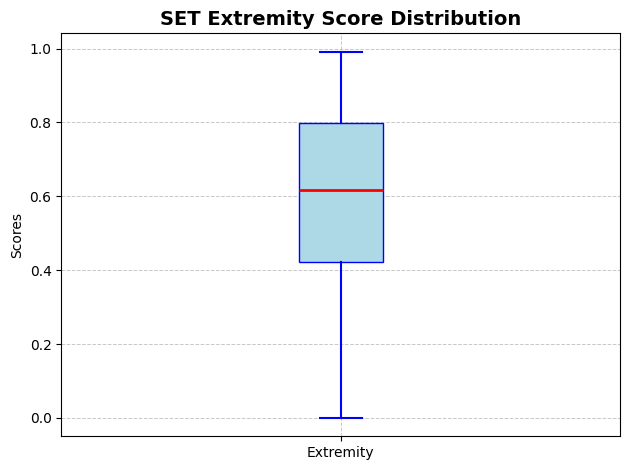

In [17]:
# Create box plot with the SET review extremity scores

set_df["Extremity"].plot.box(
    patch_artist=True,  # Enable custom colors
    boxprops=dict(facecolor='lightblue', color='blue'),  # box
    medianprops=dict(color='red', linewidth=2),  # median line
    whiskerprops=dict(color='blue', linewidth=1.5),  # whiskers
    capprops=dict(color='blue', linewidth=1.5),  # caps
    flierprops=dict(marker='o', color='orange', alpha=0.5),  # outliers
)

plt.title("SET Extremity Score Distribution", fontsize=14, fontweight='bold')
plt.ylabel('Scores')

# Customizing the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Adding some padding
plt.tight_layout()

plt.show()

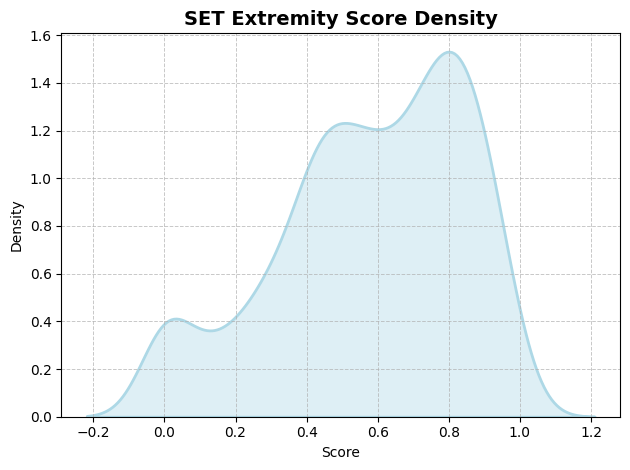

In [18]:
#  Create a kernel density plot for the extremity scores

sns.kdeplot(set_df["Extremity"], 
            color='lightblue',  # Set line color
            fill=True,  # Fill under the KDE curve
            alpha=0.4,  # Transparency of the fill
            linewidth=2)  # Thickness of the line

# Add title and labels
plt.title("SET Extremity Score Density", fontsize=14, fontweight='bold')
plt.xlabel('Score')  # X-axis label
plt.ylabel('Density')  # Y-axis label

# Add a grid with custom style
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

### tCF Data

#### Most frequent Adjectives

In [19]:
# tokenize each word within a review
tcf_df['Tokenized Review'] = tcf_df['Review Text'].apply(lambda text: word_tokenize(text))

In [20]:
from collections import Counter

# find all adjectives within each review
all_adjectives = []
for tokens in tcf_df['Tokenized Review']:
    tagged_tokens = nltk.pos_tag(tokens)
    adjectives = [word for word, pos in tagged_tokens if pos.startswith('JJ')]
    all_adjectives.extend(adjectives)

# consolidate the adjectives into a list and produce counts for each adjectives
filtered_adjectives = [adj for adj in all_adjectives if adj.lower() not in stopwords]
adjective_counts = Counter(filtered_adjectives)
most_common_adjectives = adjective_counts.most_common(10)
print(most_common_adjectives)

[('final', 145), ('good', 106), ('great', 88), ('hard', 81), ('easy', 70), ('interesting', 65), ('difficult', 55), ('sure', 44), ('much', 34), ('first', 32)]


Word Cloud

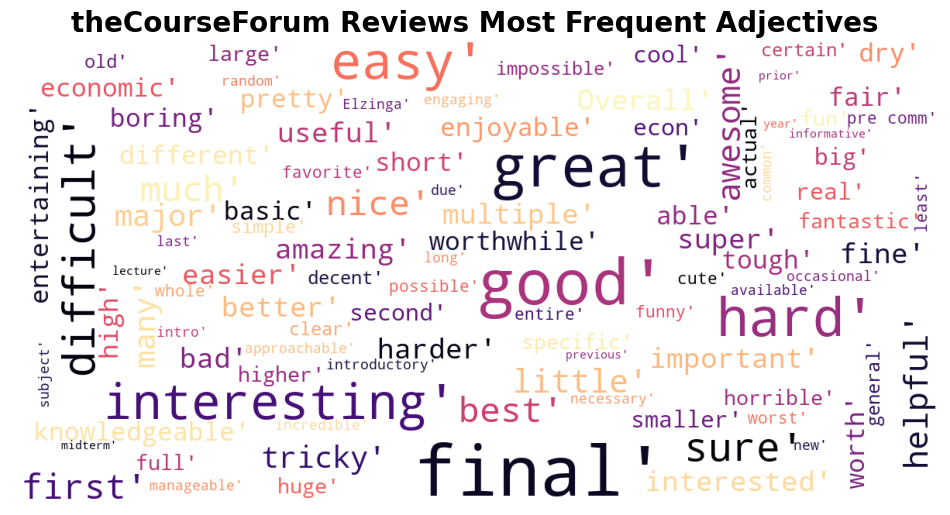

In [21]:
# generate word cloud using the inputed word list data
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1,
        colormap="magma")

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.title("theCourseForum Reviews Most Frequent Adjectives", fontsize=20, fontweight='bold')
    plt.show()

# use only the adjectives
show_wordcloud(filtered_adjectives)

Compund Score Analysis

In [22]:
var = "Compound Score"
# find general statistics of the compound score distribution
print(tcf_df[var].describe(),'\n')

count    408.000000
mean       0.560070
std        0.462090
min       -0.946800
25%        0.370875
50%        0.729550
75%        0.896675
max        0.997200
Name: Compound Score, dtype: float64 



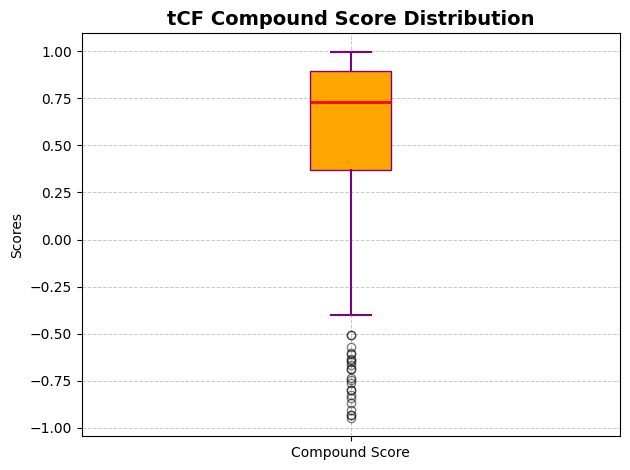

In [23]:
# Create box plot with the theCourseForum review compound scores

tcf_df[var].plot.box(
    patch_artist=True,  # Enable custom colors
    boxprops=dict(facecolor='orange', color='purple'),  # box
    medianprops=dict(color='red', linewidth=2),  # median line
    whiskerprops=dict(color='purple', linewidth=1.5),  # whiskers
    capprops=dict(color='purple', linewidth=1.5),  # caps
    flierprops=dict(marker='o', color='orange', alpha=0.5),  # outliers
)

plt.title("tCF Compound Score Distribution", fontsize=14, fontweight='bold')
plt.ylabel('Scores')

# Customizing the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Adding some padding
plt.tight_layout()

plt.show()

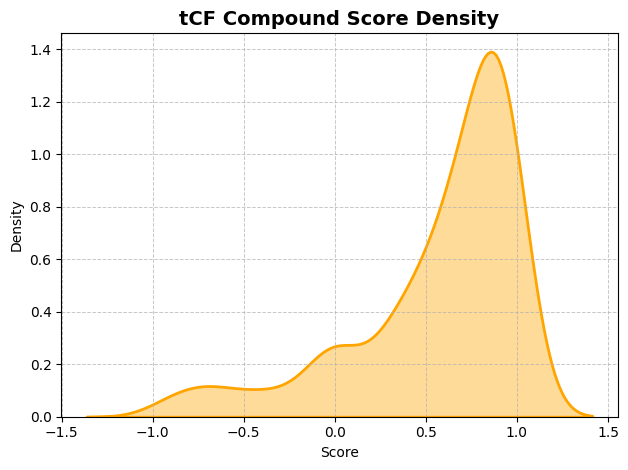

In [24]:
# Create a kernel density plot for the compound score

sns.kdeplot(tcf_df[var], 
            color='orange',  # Set line color
            fill=True,  # Fill under the KDE curve
            alpha=0.4,  # Transparency of the fill
            linewidth=2)  # Thickness of the line

# Add title and labels
plt.title("tCF Compound Score Density", fontsize=14, fontweight='bold')
plt.xlabel('Score')  # X-axis label
plt.ylabel('Density')  # Y-axis label

# Add a grid with custom style
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

##### Comments with the top 5 highest scores

In [25]:
# Organize based on top 5 compound scores
tcf_df.sort_values(by=["Compound Score"], ascending=True).head()

,Semester,Last Updated,Review Text,Upvotes,Downvotes,Review Average,Instr Rating,Enoyability,Recommend,Difficulty,Hours Per Week,Compound Score,Positive Score,Neutral Score,Negative Score,Extremity,Tokenized Review
168,Fall 2012,12/19/12,This was the worst class I have taken at UVA.(...,0,0,1.00,1,1,1,1,1,-0.9468,0.026,0.740,0.235,0.9468,"[This, was, the, worst, class, I, have, taken,..."
82,Fall 2016,12/17/16,I don't really have a problem with Elzinga. A...,2,0,2.00,2,2,2,4,2,-0.9291,0.083,0.773,0.144,0.9291,"[I, do, n't, really, have, a, problem, with, E..."
140,Fall 2013,12/13/13,I took this because I thought it would be inte...,0,0,2.33,3,2,2,3,0,-0.9290,0.059,0.648,0.292,0.9290,"[I, took, this, because, I, thought, it, would..."
11,Fall 2022,12/14/22,Kenneth Elzinga is a senile jerk who literally...,1,0,1.00,1,1,1,4,6,-0.9052,0.058,0.720,0.222,0.9052,"[Kenneth, Elzinga, is, a, senile, jerk, who, l..."
315,Fall 2009,12/15/08,Elzinga's class has two faces. Everyone has he...,0,0,4.67,4,5,5,3,0,-0.8674,0.106,0.737,0.157,0.8674,"[Elzinga, 's, class, has, two, faces, ., Every..."


In [26]:
# Organize based on top 5 extremity
tcf_df.sort_values(by=["Extremity"], ascending=False).head()

,Semester,Last Updated,Review Text,Upvotes,Downvotes,Review Average,Instr Rating,Enoyability,Recommend,Difficulty,Hours Per Week,Compound Score,Positive Score,Neutral Score,Negative Score,Extremity,Tokenized Review
130,Fall 2013,1/02/14,Elzinga is a legend. Take this course. Whether...,7,2,5.00,5,5,5,3,4,0.9972,0.193,0.798,0.009,0.9972,"[Elzinga, is, a, legend, ., Take, this, course..."
117,Fall 2014,1/04/15,"Elzinga is a really cute and caring guy, but m...",0,0,2.33,3,2,2,4,3,0.9961,0.289,0.695,0.016,0.9961,"[Elzinga, is, a, really, cute, and, caring, gu..."
70,Fall 2017,12/10/17,This class is awesome. Unlike a lot of other c...,1,1,5.00,5,5,5,3,9,0.9954,0.193,0.793,0.014,0.9954,"[This, class, is, awesome, ., Unlike, a, lot, ..."
227,Fall 2010,9/16/10,Elzinga is totally awesome. This class is rea...,0,0,5.00,5,5,5,1,0,0.9941,0.273,0.638,0.089,0.9941,"[Elzinga, is, totally, awesome, ., This, class..."
66,Fall 2017,12/16/17,"Honestly, I don't get all the hype about Profe...",5,1,2.67,3,2,3,2,5,0.9938,0.204,0.773,0.023,0.9938,"[Honestly, ,, I, do, n't, get, all, the, hype,..."


### Extremity Score Analysis
In the next few cells, we will analyze the extremity of the SET evaluations.

In [27]:
# find general statistics of the extremity distribution
tcf_df["Extremity"].describe()

count    408.000000
mean       0.667439
std        0.285320
min        0.000000
25%        0.492300
50%        0.750650
75%        0.898825
max        0.997200
Name: Extremity, dtype: float64

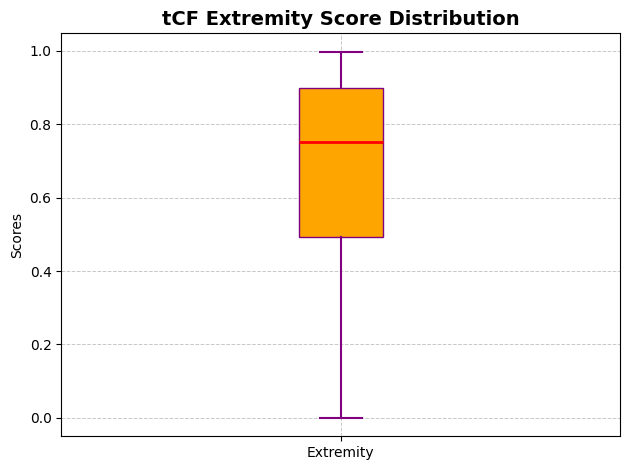

In [28]:
# Create box plot with the theCourseForum review extremity scores

tcf_df["Extremity"].plot.box(
    patch_artist=True,  # Enable custom colors
    boxprops=dict(facecolor='orange', color='purple'),  # box
    medianprops=dict(color='red', linewidth=2),  # median line
    whiskerprops=dict(color='purple', linewidth=1.5),  # whiskers
    capprops=dict(color='purple', linewidth=1.5),  # caps
    flierprops=dict(marker='o', color='orange', alpha=0.5),  # outliers
)

plt.title("tCF Extremity Score Distribution", fontsize=14, fontweight='bold')
plt.ylabel('Scores')

# Customizing the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Adding some padding
plt.tight_layout()

plt.show()

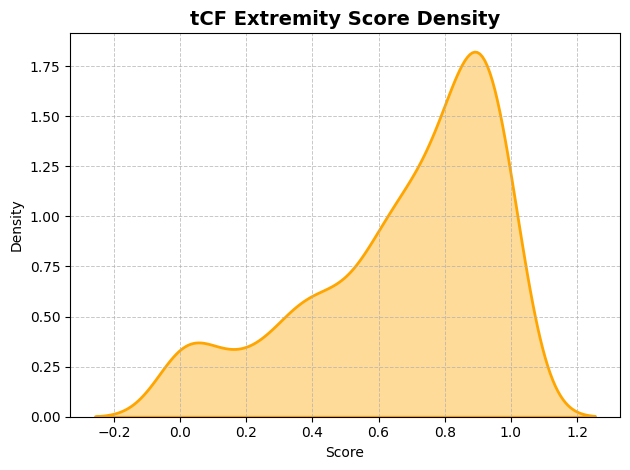

In [29]:
#  Create a kernel density plot for the extremity scores

sns.kdeplot(tcf_df["Extremity"], 
            color='orange',  # Set line color
            fill=True,  # Fill under the KDE curve
            alpha=0.4,  # Transparency of the fill
            linewidth=2)  # Thickness of the line

# Add title and labels
plt.title("tCF Extremity Score Density", fontsize=14, fontweight='bold')
plt.xlabel('Score')  # X-axis label
plt.ylabel('Density')  # Y-axis label

# Add a grid with custom style
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

In [30]:
# finding variance within theCourseForum compound reviews
variance_compound_score = tcf_df['Compound Score'].var()
print(f"Variance of Compound Score: {variance_compound_score}")

# finding variance within theCourseForum compound reviews without covid reviews
tcf_df_noCovid = tcf_df[~tcf_df['Semester'].str.contains('Fall 2020')]

variance_compound_score_noCovid = tcf_df_noCovid['Compound Score'].var()
print(f"Variance of Compound Score (after removing 2020 data): {variance_compound_score_noCovid}")

Variance of Compound Score: 0.21352749919201958
Variance of Compound Score (after removing 2020 data): 0.21415790312780547


## Welch's T-Test for Significance
Test if there is a significant difference with how extreme the language of reviews are between SET reviews and tCF reviews.


In [31]:
# first, print out the size of the final overall dataset
df.shape

(1022, 7)

In [32]:
from scipy.stats import ttest_ind

# Perform Welch's t-test: Testing the difference in language extremity (the absolute value of the compoind score) between 
t_statistic, p_value = ttest_ind(tcf_df["Extremity"], set_df["Extremity"], equal_var=False)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
  print("The difference in Extremity scores between TCF and SET is statistically significant.")
else:
  print("The difference in Extremity scores between TCF and SET is not statistically significant.")

T-statistic: 4.964152612589995
P-value: 8.3910024482673e-07
The difference in Extremity scores between TCF and SET is statistically significant.
